In [1]:
import cv2
import pandas as pd
import numpy as np
from os import walk
from matplotlib import pyplot as plt
import imutils

In [2]:
from google.colab import drive
drive.mount("/content/drive")
folder_name = ("/content/drive/MyDrive/3d-part-project/")

Mounted at /content/drive


In [ ]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa

def augment_images(images, labels=[], return_labels=False, iter_augmentations=1):

  """
  # Example batch of images.
  # The array has shape (32, 64, 64, 3) and dtype uint8.
  images = np.array(
      [ia.quokka(size=(64, 64)) for _ in range(32)],
      dtype=np.uint8
  )
  """

  seq = iaa.Sequential([
      #iaa.Fliplr(0.5), # horizontal flips
      iaa.Crop(percent=(0, 0.1)), # random crops
      # Small gaussian blur with random sigma between 0 and 0.5.
      # But we only blur about 50% of all images.
      #iaa.Sometimes(
          #0.5,
          #iaa.GaussianBlur(sigma=(0, 0.5))
      #),
      # Strengthen or weaken the contrast in each image.
      #iaa.LinearContrast((0.75, 1.5)),
      # Add gaussian noise.
      # For 50% of all images, we sample the noise once per pixel.
      # For the other 50% of all images, we sample the noise per pixel AND
      # channel. This can change the color (not only brightness) of the
      # pixels.
      #iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
      # Make some images brighter and some darker.
      # In 20% of all cases, we sample the multiplier once per channel,
      # which can end up changing the color of the images.
      #iaa.Multiply((0.8, 1.2), per_channel=0.2),
      # Apply affine transformations to each image.
      # Scale/zoom them, translate/move them, rotate them and shear them.
      iaa.Affine(
          scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
          translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
          #rotate=(-25, 25),
          #shear=(-8, 8)
      )
  ], random_order=True) # apply augmenters in random order

  images_aug = []
  labels_aug = []
  for i in range(iter_augmentations):
    images_aug.extend(seq(images=images))
    labels_aug.extend(labels) # Can do it like this, since the images get appended in the same order in the seq() method.

  output = images_aug
  if return_labels == True:
    output = images_aug, labels_aug
  return output

plt.imshow(ia.quokka(size=(64, 64)))
plt.show()

augmented_images = augment_images([ia.quokka(size=(64,64)), ia.quokka(size=(64,64))], iter_augmentations=2)
print("len(augmented_images):", len(augmented_images))
plt.imshow(augmented_images[0])
plt.show()

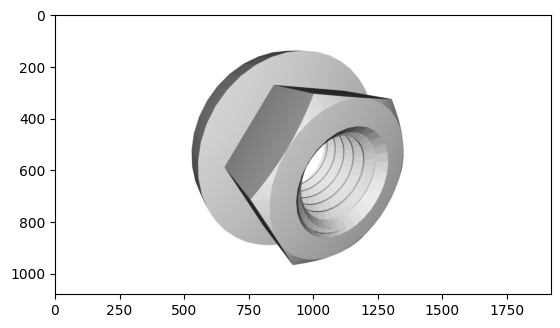

(1080, 1920, 3)
(1080, 1920)


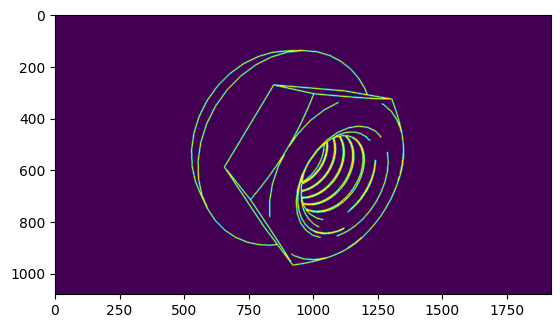

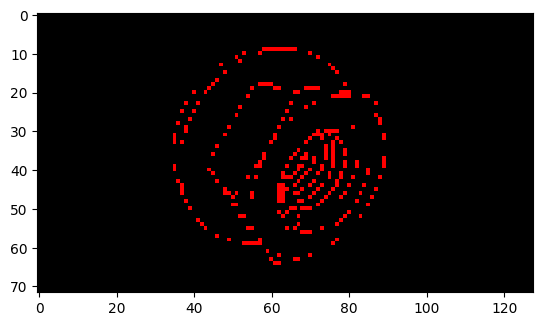

(72, 128, 3)


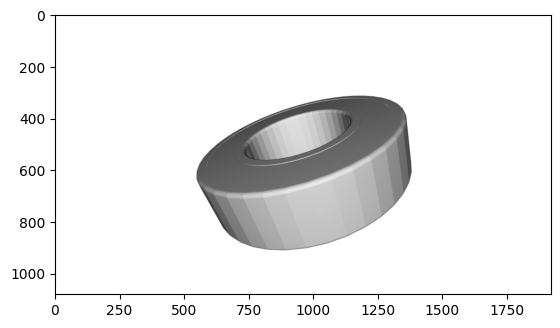

(1080, 1920, 3)
(1080, 1920)


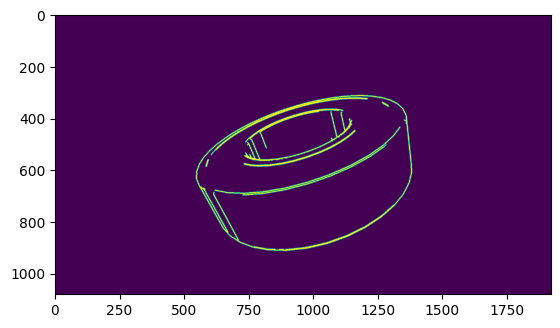

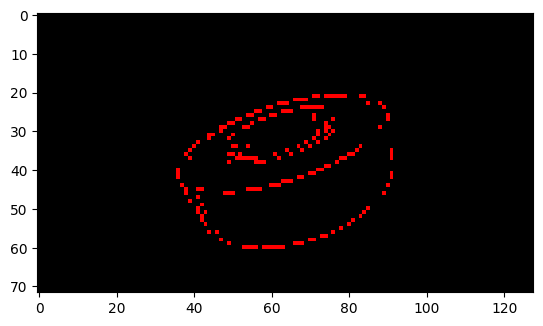

(72, 128, 3)


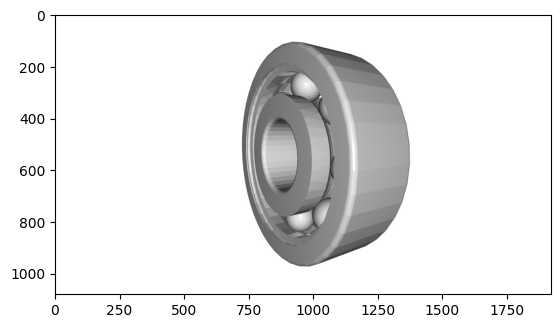

(1080, 1920, 3)
(1080, 1920)


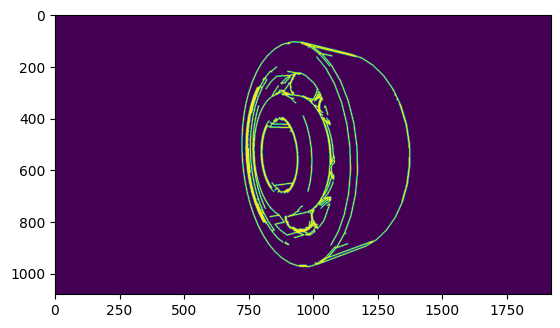

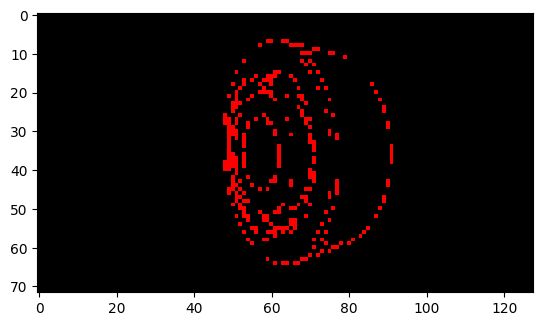

(72, 128, 3)


In [5]:
import os

list_image_names = []
labels = []

subdirs = [x[0] for x in os.walk(folder_name)]
for subdir in subdirs:
    files = os.walk(subdir).__next__()[2]
    if (len(files) > 0):
        for file in files:
            # Create the name of file with correct label from folder name
            label = subdir.split("/")[-1]
            labels.append(label)
            list_image_names.append(os.path.join(subdir, file))

img_list = []
index = 0
for image_name in list_image_names:
    index += 1
    if index not in [1, 600, 1100]:
      continue

    image = cv2.imread(image_name)

    # Detect the contours
    gray = cv2.bilateralFilter(image, 3, 5, 5)
    edged = cv2.Canny(gray, 100, 200)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    img = cv2.cvtColor(edged, cv2.COLOR_GRAY2BGR)  #add this line
    img = cv2.drawContours(img, cnts, -1, 255, 3)
    #im_bw = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]

    # resize the image to a fixed size. Resize AFTER detecting the edges
    #image = cv2.resize(image, (896, 504)) # 896 x 504 = ratio of 1920 x 1080 downscaled
    image_resized = cv2.resize(img, (128, 72))

    plt.imshow(image)
    plt.show()
    print(img.shape)
    img = img[:,:,0]
    print(img.shape)
    plt.imshow(img)
    plt.show()
    plt.imshow(image_resized)
    plt.show()
    print(image_resized.shape)
    img_list.append(image_resized)



len(img_list): 3
len(augmented_images): 3


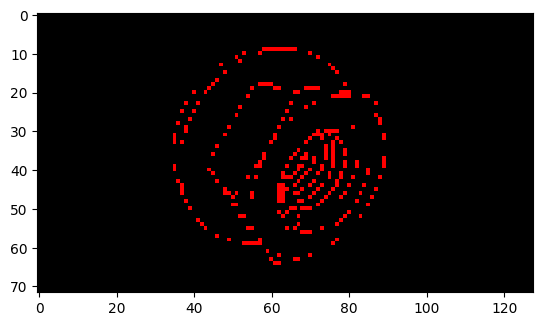

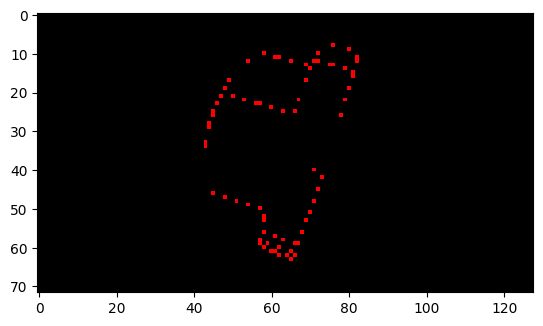

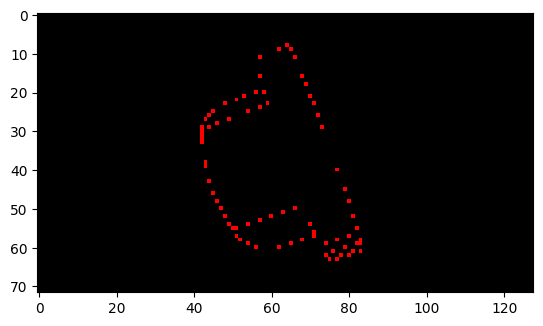

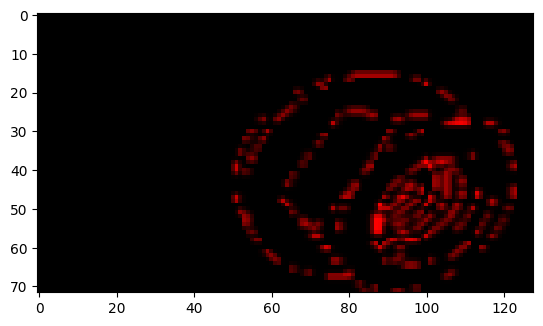

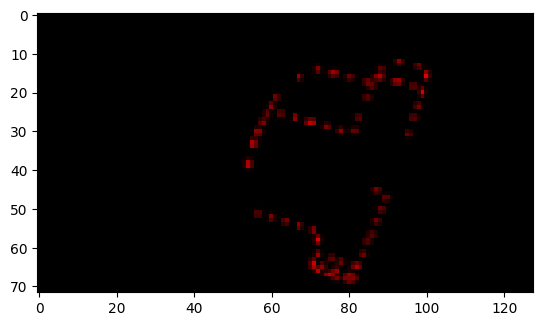

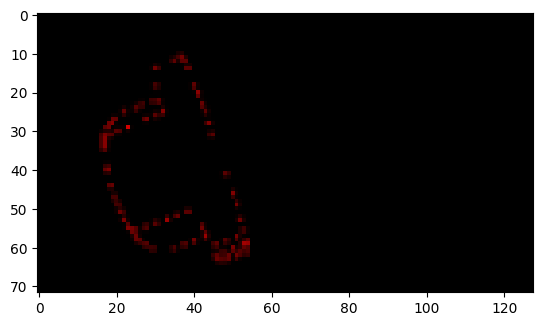

In [ ]:
print("len(img_list):", len(img_list))
augmented_images = augment_images(img_list)
print("len(augmented_images):", len(augmented_images))
img_list.extend(augmented_images)

for img in img_list:
  plt.imshow(img)
  plt.show()

In [ ]:
sample = img_list[0]
print("type:", type(sample))
print("max:", np.max(sample))
print("min:", np.min(sample))
print("avg:", np.average(sample))
unique, counts = np.unique(sample, return_counts=True)
print("unique values:", unique)
print("counts       :", counts)

type: <class 'numpy.ndarray'>
max: 255
min: 0
avg: 2.4256727430555554
unique values: [  0 255]
counts       : [27385   263]


### Training

In [ ]:
import os

list_image_names = []
labels = []

subdirs = [x[0] for x in os.walk(folder_name)]
for subdir in subdirs:
    files = os.walk(subdir).__next__()[2]
    if (len(files) > 0):
        for file in files:
            # Create the name of file with correct label from folder name
            label = subdir.split("/")[-1]
            labels.append(label)
            list_image_names.append(os.path.join(subdir, file))

img_list = []
for image_name in list_image_names:
    image = cv2.imread(image_name)

    # resize the image to a fixed size before edge detection
    image = cv2.resize(image, (128, 72)) # Keeps the 16:9 aspect ratio

    # Detect the contours
    gray = cv2.bilateralFilter(image, 3, 5, 5)
    edged = cv2.Canny(gray, 100, 200)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    img = cv2.cvtColor(edged, cv2.COLOR_GRAY2BGR)  #add this line
    img = cv2.drawContours(img, cnts, -1, (136, 231, 46), 3)
    #im_bw = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]

    img = img[:,:,0] # Reducing the dimensions of the image to 1, since it is only grayscaled

    # Flatten image from 2 dimensions to 1 dimensional vector. Not needed for CNN.
    #img = img.flatten()

    # resizing after edge detection
    #img = cv2.resize(img, (100, 100))

    img_list.append(img)


### Augemented images?
"""
# Image Augmentation. Good when dealing with real world images, since they differ quite a bit
augmented_images, augmented_labels = augment_images(img_list, labels=labels, iter_augmentations=5, return_labels=True)
img_list.extend(augmented_images)
labels.extend(augmented_labels)
"""



'\n# Image Augmentation. Good when dealing with real world images, since they differ quite a bit\naugmented_images, augmented_labels = augment_images(img_list, labels=labels, iter_augmentations=5, return_labels=True)\nimg_list.extend(augmented_images)\nlabels.extend(augmented_labels)\n'

In [ ]:
print("len(img_list):", len(img_list))
print("len(labels):", len(labels))

len(img_list): 1536
len(labels): 1536


In [ ]:
from sklearn.model_selection import train_test_split

img_list = np.array(img_list)
labels = np.array(labels)

# Encode the labels with the possibility of decoding later
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(labels)
labels = label_encoder.transform(labels)
#label_encoder.inverse_transform(labels)

xtrain, xtest, ytrain, ytest = train_test_split(img_list, labels, stratify=labels, test_size=0.20) # Stratify makes sure that the ration is even in the test set

u, counts = np.unique(ytest, return_counts=True)
print("classes:", u)
print("counts :", counts)

classes: [0 1 2]
counts : [103 103 102]


In [ ]:
"""
from torch.utils.data import DataLoader
# dataloaders
batch_size = 8
trainloader = DataLoader((xtrain, ytrain), batch_size=batch_size,
                                        shuffle=True, num_workers=1)


testloader = DataLoader((xtest, ytest), batch_size=batch_size,
                                        shuffle=False, num_workers=1)
"""

'\nfrom torch.utils.data import DataLoader\n# dataloaders\nbatch_size = 8\ntrainloader = DataLoader((xtrain, ytrain), batch_size=batch_size,\n                                        shuffle=True, num_workers=1)\n\n\ntestloader = DataLoader((xtest, ytest), batch_size=batch_size,\n                                        shuffle=False, num_workers=1)\n'

Epoch 1/7
39/39 [==============================] - 23s 546ms/step - loss: 2.6678 - accuracy: 0.5480 - val_loss: 0.5884 - val_accuracy: 0.7435
Epoch 2/7
39/39 [==============================] - 23s 585ms/step - loss: 0.4066 - accuracy: 0.8322 - val_loss: 0.3489 - val_accuracy: 0.8409
Epoch 3/7
39/39 [==============================] - 21s 535ms/step - loss: 0.2365 - accuracy: 0.9064 - val_loss: 0.2445 - val_accuracy: 0.8864
Epoch 4/7
39/39 [==============================] - 23s 588ms/step - loss: 0.1855 - accuracy: 0.9259 - val_loss: 0.2529 - val_accuracy: 0.8799
Epoch 5/7
39/39 [==============================] - 23s 597ms/step - loss: 0.1319 - accuracy: 0.9471 - val_loss: 0.1983 - val_accuracy: 0.9253
Epoch 6/7
39/39 [==============================] - 24s 610ms/step - loss: 0.0909 - accuracy: 0.9682 - val_loss: 0.2053 - val_accuracy: 0.9058
Epoch 7/7
39/39 [==============================] - 21s 539ms/step - loss: 0.0603 - accuracy: 0.9756 - val_loss: 0.1589 - val_accuracy: 0.9253
10/10 

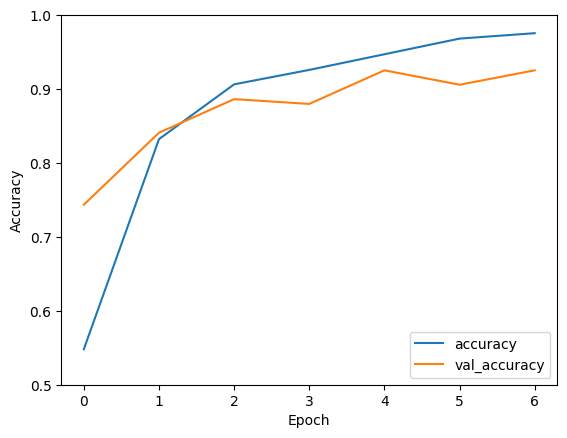

In [ ]:
# CNN
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(72, 128, 1))) # input shape depends on image size
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dropout(rate=0.3))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(xtrain, ytrain, epochs=7, validation_data=(xtest, ytest))
#history = model.fit(xtrain, ytrain, epochs=10)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(xtest, ytest, verbose=2)

print("Accuracy:", test_acc)


10/10 [==============================] - 3s 274ms/step
['6200_c3' '6800zz' 'nutflm10']

class 0 : 6200_c3
class 1 : 6800zz
class 2 : nutflm10

[[ 97   6   0]
 [ 14  88   1]
 [  1   1 100]]


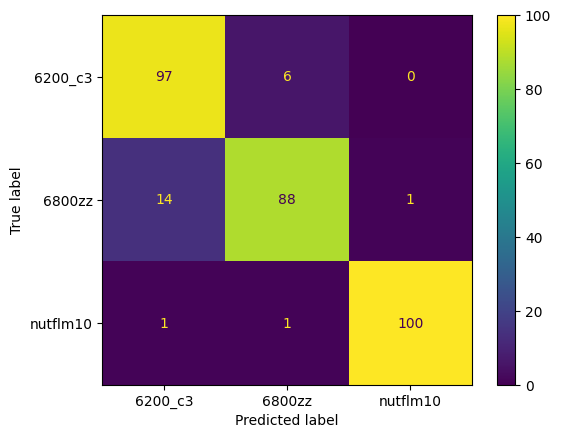

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = model.predict(xtest)
predicted_labels = np.argmax(predictions, axis=1)

class_labels = label_encoder.inverse_transform(np.unique(labels))
conf_matrix = confusion_matrix(ytest, predicted_labels, labels=np.unique(labels))

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot()
plt.show()